In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
from tensorflow import keras

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [3]:
IMAGE_SIZE = 1024
BATCH_SIZE = 1
NUM_CLASSES = 13
DATA_DIR = r"\\fatherserverdw\kyuex\great\tiles"
train_images = sorted(glob(os.path.join(*[DATA_DIR, 'training',"im/*png"])))
train_masks = sorted(glob(os.path.join(*[DATA_DIR, 'training',"label/*png"])))
val_images = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"im/*png"])))
val_masks = sorted(glob(os.path.join(*[DATA_DIR, 'validation',"label/*png"])))

In [4]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    # image = cv2.imread(image_path.decode('UTF-8'))
    if mask:
        image = tf.image.decode_png(image, channels=1) #channels=1. output greyscale image
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image[image==13]=0
        image = tf.where(tf.equal(image, 13), tf.zeros_like(image), image)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        # image = image / 127.5 - 1 #[-1 1]
        image = image/255 #[0 1]
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [5]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset shapes: ((1, 1024, 1024, 3), (1, 1024, 1024, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((1, 1024, 1024, 3), (1, 1024, 1024, 1)), types: (tf.float32, tf.float32)>


In [6]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = keras.layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = keras.layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)
    input_a = keras.layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    x = keras.layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = keras.layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = keras.layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 512, 512, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 512, 512, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
## Training

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    # optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=["accuracy"],
)

checkpoint_path = "fold_5/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1,
                                                 )
earlystop = keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch%2:
        return lr
    else:
        return lr * 0.1

lrschedule = keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
round(model.optimizer.lr.numpy(), 5)

1e-04

In [8]:
start = time()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=40,callbacks=[cp_callback,earlystop,lrschedule])
print(np.around(time()-start),'seconds elapsed')
round(model.optimizer.lr.numpy(), 5)

Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
10/10 [==============================] - 17s 380ms/step - loss: 2.4005 - accuracy: 0.2242 - val_loss: nan - val_accuracy: 0.3842

Epoch 00001: val_accuracy improved from -inf to 0.38419, saving model to fold_5\cp.ckpt
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
10/10 [==============================] - 3s 308ms/step - loss: 1.5591 - accuracy: 0.5666 - val_loss: nan - val_accuracy: 0.3842

Epoch 00002: val_accuracy did not improve from 0.38419
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
10/10 [==============================] - 3s 306ms/step - loss: 1.1704 - accuracy: 0.6790 - val_loss: nan - val_accuracy: 0.3842

Epoch 00003: val_accuracy did not improve from 0.38419
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
10/10 [===========================

1e-04

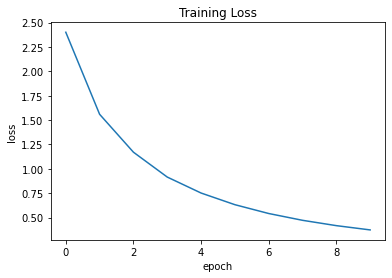

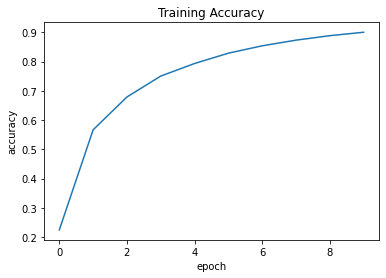

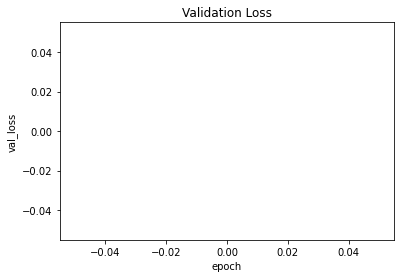

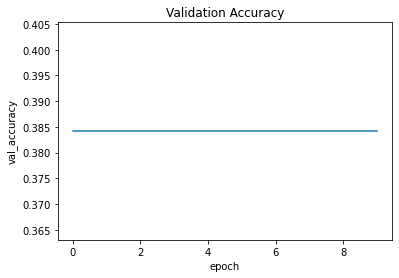

In [9]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()